<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Sun Aug  6 22:21:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 462.62       Driver Version: 462.62       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1650   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8     3W /  N/A |    134MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
from argparse import ArgumentParser

parser = ArgumentParser()

parser.add_argument("--disable-cuda", default=False)
parser.add_argument("-f", required=False)

arg = parser.parse_args()
arg.device = None
if not arg.disable_cuda and torch.cuda.is_available():
    arg.device = torch.device("cuda:0")
else:
    arg.device = torch.device("cpu")
    
arg.device

2.0.1+cu117


device(type='cuda', index=0)

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [20]:
def download_data():
    pass

# 1. Get data
from pathlib import Path
data_dir = Path("../../module/data") / "pizza_steak_sushi"


if data_dir.is_dir():
    print("Data has been downloaded. Skip...")
else:
    print("Downloading...")
    download_data()

Data has been downloaded. Skip...


In [21]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
walk_through_dir(data_dir)

There are 2 directories and 1 images in '..\..\module\data\pizza_steak_sushi'.
There are 3 directories and 0 images in '..\..\module\data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in '..\..\module\data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in '..\..\module\data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in '..\..\module\data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in '..\..\module\data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in '..\..\module\data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in '..\..\module\data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in '..\..\module\data\pizza_steak_sushi\train\sushi'.


In [35]:
# Setup train and testing paths
train_path = data_dir / "train"
test_path = data_dir / "test"

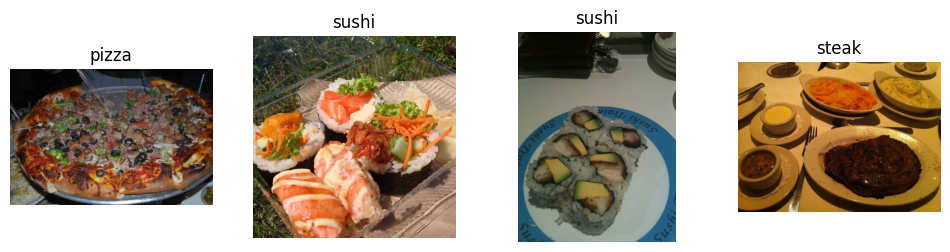

In [37]:
# Visualize an image
from PIL import Image
from glob import glob
import random
import matplotlib.pyplot as plt

image_list_path = sorted(list(train_path.glob("*/*.jpg")))



def visualize_image(image_paths: str,
                    n: int = 4, 
                    seed: int = 82) -> None:
    image_list_path = sorted(list(image_paths.glob("*/*.jpg")))
    random.seed(seed)
    plt.figure(figsize=(12, 6))
    for idx, image_path in enumerate(random.sample(image_list_path, k=n)):
        plt.subplot((n // 4) + 1, 4, idx + 1)
        image = Image.open(image_path)
        class_name = image_path.parent.stem
        
        plt.imshow(image)
        plt.title(class_name)
        plt.axis(False)
        
    
    

visualize_image(test_path)

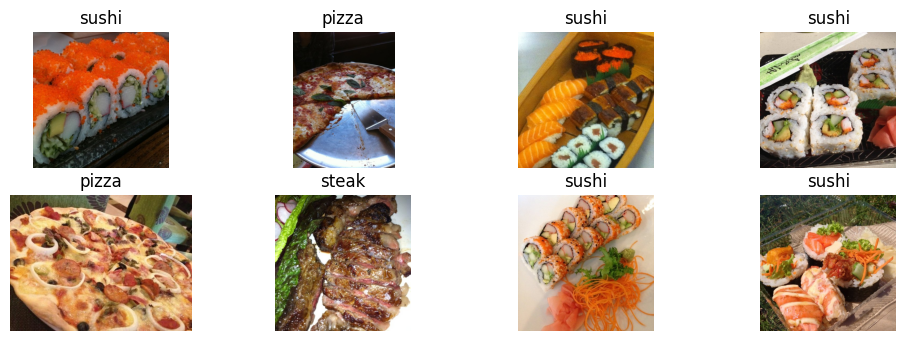

In [38]:
# Do the image visualization with matplotlib
visualize_image(test_path, n = 8, seed = 10)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [47]:
# 3.1 Transforming data with torchvision.transforms
from torchvision.transforms import Compose, TrivialAugmentWide, \
                                   ToTensor, Resize, \
                                   Normalize \

train_transform = Compose([
    Resize((64, 64)),
    TrivialAugmentWide(num_magnitude_bins=2),
    ToTensor(),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transform = Compose([
    Resize((64, 64)),
    ToTensor(),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


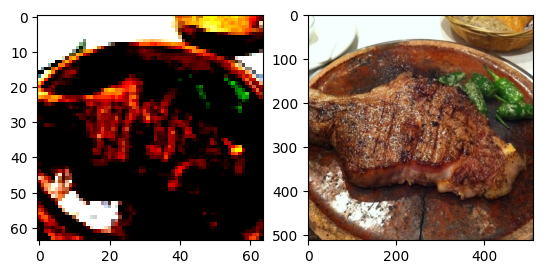

In [59]:
# Write transform for turning images into tensors
image = Image.open(image_list_path[82])

plt.subplot(1, 2, 1)
plt.imshow(train_transform(image).permute(1, 2, 0))

plt.subplot(1, 2, 2)
plt.imshow(image)

In [10]:
# Write a function to plot transformed images


### Load image data using `ImageFolder`

In [62]:
# Use ImageFolder to create dataset(s)
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(root=train_path, transform=train_transform, target_transform=None)

test_dataset = ImageFolder(root=test_path, transform=test_transform, target_transform=None)

In [64]:
# Get class names as a list
class_names = train_dataset.classes
class_names

['pizza', 'steak', 'sushi']

In [65]:
# Can also get class names as a dict
class_dict = train_dataset.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [67]:
# Check the lengths of each dataset
len(train_dataset), len(test_dataset)

(225, 75)

In [69]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
batch_size = 64
num_workers = os.cpu_count()

train_dataloader = DataLoader(dataset=train_dataset,
                               batch_size=batch_size,
                               num_workers=num_workers,
                               shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                               batch_size=batch_size,
                               num_workers=num_workers,
                               shuffle=True)

In [71]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(4, 2)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [78]:
class TinyModel(nn.Module):
    def __init__(self, in_channels: int,  out_classes: int, hidden_units: int = 10) -> None:
        super(TinyModel, self).__init__()
        
        self.maxpool = nn.MaxPool2d(2)
        self.block_1 = self._block(in_channels = in_channels, out_channels = hidden_units)
        self.block_2 = self._block(in_channels=hidden_units, out_channels=out_classes)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.maxpool(self.block_1(x) + x)
        x = self.maxpool(self.block_2(x) + x)
        return x
        
    
    def _block(self, in_channels: int, 
               out_channels: int, 
               kernel_size: int = 3, 
               stride: int = 1, 
               padding: int = 1) -> nn.Module:
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
            nn.ReLU(),
        )
    
model_0 = TinyModel(in_channels=3, out_classes=3).to(arg.device)
model_0

TinyModel(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (block_2): Sequential(
    (0): Conv2d(10, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
)

## 4. Create training and testing functions for `model_0`.

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
 
    # Send data to target device

    # 1. Forward pass
    
    # 2. Calculate and accumulate loss
    

    # 3. Optimizer zero grad 
    

    # 4. Loss backward 
    

    # 5. Optimizer step
    

    # Calculate and accumualte accuracy metric across all batches
   

  # Adjust metrics to get average loss and average accuracy per batch
  

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  
    # Loop through DataLoader batches
    
      # Send data to target device
      

      # 1. Forward pass
      

      # 2. Calculuate and accumulate loss


      # Calculate and accumulate accuracy

    
  # Adjust metrics to get average loss and accuracy per batch


In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [ ]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(#TODO, 
                             lr=0.001)

In [ ]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(#TODO, 
                             lr=0.001)

In [ ]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(#TODO, 
                             lr=0.001)

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [ ]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)


It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [ ]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

In [ ]:
# See how many images we have
walk_through_dir(image_path)

Excellent, we now have double the training and testing images... 

In [ ]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

In [ ]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),                                     
  transforms.ToTensor()
])

# Create datasets


# Create dataloaders


In [ ]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?